In [2]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

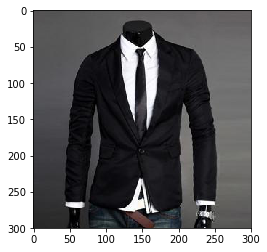

In [3]:
img=plt.imread('img/Single-Button_Blazer/img_00000001.jpg')
imgplot = plt.imshow(img)

In [95]:
img2category = open('list_category_img.txt', 'r') 
category2type = open('list_category_cloth.txt', 'r')
img2category_lines = img2category.readlines()
category2type_lines = category2type.readlines()


labels=[]
imgs=[]
step = 10 # we get 289000/step images
category_count = {}

for i, line in enumerate(img2category_lines[2:]):
    if i % step == 0:
        img_name = line.split()[0]
        label = int(line.split()[1]) - 1 # let's make it 0-indexed
        labels.append(label)
        if label not in category_count:
            category_count[label] = 0
        category_count[label] += 1
        
        img = plt.imread(img_name)
        imgs.append(np.resize(img, (32,32,3)))

imgs_temp = np.asarray(imgs)
labels_temp = np.asarray(labels)
    
categories = [] #category #49 and #50 are not found in the dataset. Doesn't matter
category2type = {} 
    
for i, line in enumerate(category2type_lines[2:]):
    category = line.split()[0]
    category_type = int(line.split()[1])
    categories.append(category)
    category2type[i] = category_type
    

In [96]:
imgs = imgs_temp
labels = np.array([category2type[label] for label in labels_temp])

In [97]:
labels

array([1, 1, 1, ..., 3, 3, 3])

In [98]:
print(len(categories))
print(categories)
print(len(labels))
print(category_count)
print(category2type)

50
['Anorak', 'Blazer', 'Blouse', 'Bomber', 'Button-Down', 'Cardigan', 'Flannel', 'Halter', 'Henley', 'Hoodie', 'Jacket', 'Jersey', 'Parka', 'Peacoat', 'Poncho', 'Sweater', 'Tank', 'Tee', 'Top', 'Turtleneck', 'Capris', 'Chinos', 'Culottes', 'Cutoffs', 'Gauchos', 'Jeans', 'Jeggings', 'Jodhpurs', 'Joggers', 'Leggings', 'Sarong', 'Shorts', 'Skirt', 'Sweatpants', 'Sweatshorts', 'Trunks', 'Caftan', 'Cape', 'Coat', 'Coverup', 'Dress', 'Jumpsuit', 'Kaftan', 'Kimono', 'Nightdress', 'Onesie', 'Robe', 'Romper', 'Shirtdress', 'Sundress']
28923
{0: 16, 1: 753, 2: 2455, 3: 30, 4: 32, 5: 1325, 6: 33, 7: 2, 8: 69, 9: 405, 10: 1049, 11: 77, 12: 66, 13: 10, 14: 77, 15: 1315, 16: 1556, 17: 3682, 18: 1003, 19: 16, 20: 8, 21: 53, 22: 49, 23: 168, 24: 5, 25: 709, 26: 60, 27: 5, 28: 441, 29: 503, 30: 4, 31: 1979, 32: 1469, 33: 300, 34: 105, 35: 39, 36: 5, 38: 213, 39: 2, 40: 7232, 41: 614, 42: 12, 43: 227, 45: 7, 46: 14, 47: 729}
{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12:

In [99]:
order = np.arange(len(labels))
np.random.shuffle(order)

shuffled_imgs = imgs[order]
shuffled_labels = labels[order]

length = shuffled_labels.shape[0]

X_train = shuffled_imgs[:length*2//3]
y_train = shuffled_labels[:length*2//3]

X_val = shuffled_imgs[length*2//3:length*5//6]
y_val = shuffled_labels[length*2//3:length*5//6]

X_test = shuffled_imgs[length*5//6:]
y_test = shuffled_labels[length*5//6:]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (19282, 32, 32, 3)
Train labels shape:  (19282,)
Validation data shape:  (4820, 32, 32, 3)
Validation labels shape:  (4820,)
Test data shape:  (4821, 32, 32, 3)
Test labels shape:  (4821,)


In [100]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def simple_model(X,y):
    # define our weights (e.g. init_two_layer_convnet)
    
    # setup variables
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    W1 = tf.get_variable("W1", shape=[5408, 3])
    b1 = tf.get_variable("b1", shape=[3])

    # define our graph (e.g. two_layer_convnet)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,2,2,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    h1_flat = tf.reshape(h1,[-1,5408])
    y_out = tf.matmul(h1_flat,W1) + b1
    return y_out

y_out = simple_model(X,y)

# define our loss
total_loss = tf.losses.hinge_loss(tf.one_hot(y,3),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(5e-4) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)

Training
Iteration 0: with minibatch training loss = 65.7 and accuracy of 0.23
Iteration 100: with minibatch training loss = 1.35 and accuracy of 0.42
Iteration 200: with minibatch training loss = 0.992 and accuracy of 0.56
Iteration 300: with minibatch training loss = 0.681 and accuracy of 0.39
Epoch 1, Overall loss = 2.15 and accuracy of 0.429


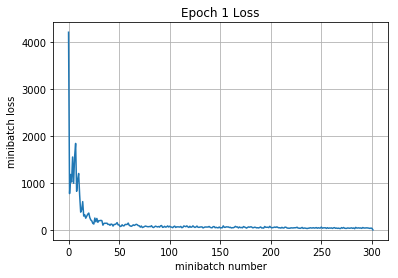

Validation
Epoch 1, Overall loss = 0.696 and accuracy of 0.424


In [101]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)